# Flower Classification on TPU
## содержание
- Введение
- Импорт библиотек
- Подключение TPU/GPU/CPU
- Общие параметры
- Общие функции
- Импорт данных
- Чтение данных
- Построение модели
- Submission

# Введение

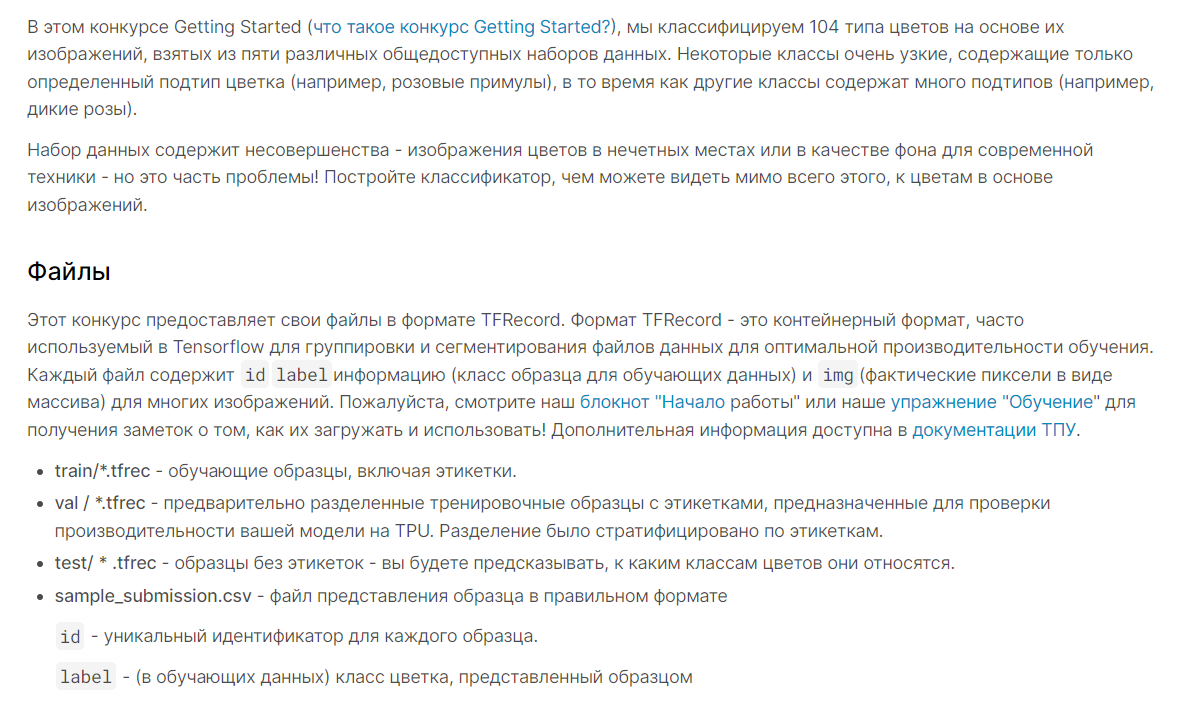

## Импорт библиотек

In [ ]:
import tensorflow as tf
import pandas as pd
from kaggle_datasets import KaggleDatasets
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import applications

## Подключение TPU/GPU/CPU

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

## Общие параметры

In [ ]:
IMAGE_SIZE = [192, 192] # при таком размере графическому процессору не хватит памяти. Используйте ТПУ
EPOCHS = 100
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

NUM_TRAINING_IMAGES = 12753
NUM_TEST_IMAGES = 7382
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
GCS_DS_PATH = KaggleDatasets().get_gcs_path() 
print(GCS_DS_PATH)

## Общие функции

 **Загрузка набора данных**

In [ ]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # преобразование изображения в плавающие значения в диапазоне [0, 1]
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # размер, необходимый для TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string означает байтовую строку
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] означает один элемент
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label #  возвращает набор данных из пар (изображение, метка)

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "id": tf.io.FixedLenFeature([], tf.string), 
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # возвращает набор изображений

def load_dataset(filenames, labeled=True, ordered=False):
   # Считывание из TFRecords. Для оптимальной производительности одновременное чтение из нескольких файлов и
   # игнорирование порядка данных. Порядок не имеет значения, так как мы все равно будем перетасовывать данные.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # отключение порядка

    dataset = tf.data.TFRecordDataset(filenames) # автоматическое чередование операций чтения из нескольких файлов
    dataset = dataset.with_options(ignore_order) 
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord)
    
    return dataset

def get_training_dataset():
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-192x192/train/*.tfrec'), labeled=True)
    dataset = dataset.repeat() 
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-192x192/val/*.tfrec'), labeled=True, ordered=False)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-192x192/test/*.tfrec'), labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

**Примеры изображений**

In [ ]:
def sample_images(images, row_count, column_count):
    fig, axs = plt.subplots(row_count, column_count, figsize=(10,10))
    for i in range(row_count):
        for j in range(column_count):
            axs[i,j].imshow(images[i * column_count + j])
            axs[i,j].axis('off')
    plt.show()

## Загрузка данных

Эти данные загружаются из Kaggle и автоматически разделяются для максимального распараллеливания.

In [ ]:
training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()

Let's see what the dataset looks like.

In [ ]:
for item in training_dataset:
    images = item[0].numpy()
    labels = item[1].numpy()
    break
images.shape, labels.shape

In [ ]:
sample_images(images, 4, 4)

# Построение модели

### Model Checkpoint

In [ ]:
checkpoint_path = "model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True)

### Установление скорости обучения

In [ ]:
LR_START = 0.00005
LR_MAX =   0.00005 * strategy.num_replicas_in_sync
LR_MIN =   0.0000025
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 6
LR_EXP_DECAY = .8
def scheduler_callback(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr =  np.random.random_sample() * LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler_callback, verbose=True)

## Ранняя остановка

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=10)

In [ ]:
callbacks = [early_stop, checkpoint, scheduler]

## Оптимизатор

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, 
                                                 beta_1=0.9, 
                                                 beta_2=0.999, 
                                                 epsilon=1e-07, 
                                                 amsgrad=False)

### Предварительная модель
Я построю Модель на основе предварительно обученных моделей Кирса. Существует множество предварительно обученных моделей, таких как Inception V3, Efficient Net 0 - 7 и так далее.

In [ ]:
model_types = [
    "dense_net", 
    "xception", 
    "inception", 
    "efficient_0", 
    "efficient_1", 
    "efficient_2", 
    "efficient_3",
    "efficient_4",
    "efficient_5",
    "efficient_6",
    "efficient_7"
]
model_type = model_types[1]
def get_pretraind_model(model_type, input_shape):
    if model_type == "dense_net":
        return applications.densenet.DenseNet121(
                include_top=False,
                input_shape=input_shape               
            )
    if model_type == "xception":
        return applications.Xception(
            include_top=False,
            input_shape=input_shape                        
        )
    if model_type == "inception":
        return applications.InceptionV3(
            include_top=False,
            input_shape=input_shape                          
        )
    if model_type == "efficient_0":
        return applications.EfficientNetB0(
            include_top=False,
                input_shape=input_shape                         
        )
    if model_type == "efficient_1":
        return applications.EfficientNetB1(
            include_top=False,
            input_shape=input_shape                         
        )
    if model_type == "efficient_2":
        return applications.EfficientNetB2(
            include_top=False,
            input_shape=input_shape                        
        )
    if model_type == "efficient_3":
        return applications.EfficientNetB3(
            include_top=False,
            input_shape=input_shape                       
        )
    if model_type == "efficient_4":
        return applications.EfficientNetB4(
            include_top=False,
            input_shape=input_shape                       
        )
    if model_type == "efficient_5":
        return applications.EfficientNetB5(
            include_top=False,
            input_shape=input_shape                       
        )
    if model_type == "efficient_6":
        return applications.EfficientNetB6(
            include_top=False,
            input_shape=input_shape                       
        )
    if model_type == "efficient_7":
        return applications.EfficientNetB7(
            include_top=False,
            input_shape=input_shape                       
        )

### Обучение модели

In [ ]:
def train(
    model_type, epochs, optimizer, callbacks, 
    strategy, layers):
    tf.keras.backend.clear_session()
    with strategy.scope():  
        input_shape = [*IMAGE_SIZE, 3]   
        pretrained_model = get_pretraind_model(model_type, input_shape)
        print(pretrained_model.summary())
        pretrained_model.trainable = True 
        all_layers = [pretrained_model] + layers + [tf.keras.layers.Dense(104, activation='softmax')]
        model = tf.keras.Sequential(all_layers)
        model.compile(
            optimizer=optimizer,
            loss = 'sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )
        history = model.fit(training_dataset, 
                            steps_per_epoch=STEPS_PER_EPOCH, 
                            epochs=epochs, 
                            validation_data=validation_dataset, 
                            callbacks=callbacks
                           )
        pd.DataFrame(history.history).plot()
        plt.show()
        return model

In [ ]:
model = train(
    model_type, EPOCHS, optimizer, callbacks, strategy, 
    layers=[
        tf.keras.layers.Dropout(0.5), 
        tf.keras.layers.GlobalAveragePooling2D(), 
        tf.keras.layers.Dropout(0.5)
    ]
)

## Submission

In [ ]:
test_ds = get_test_dataset(ordered=True) 
model.load_weights(checkpoint_path)
print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

![](http://www.kaggleusercontent.com/kf/73739038/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..wrGcdsaRMgL1y-CPtjbtvQ.TeearH2pLpqN3jx3yVf4qBKZY8Lq3bop4hI5yLKPK0dl7kI5O5W8UcQiLJipxUMOWsr7OCDrRsLcoqopqa4psq4NaG56UvwKpT4dJXYBJL-du0NN3kj1iqxFiMcA76FV3Vwn2nIAGIRBo3fQtmg5BgSFAH4QNCYaLYVc3LY49_4fhqMYRuUg6n2RRizscy-syYAIZO0XCbkRsYjzT0QU0yqlBQlBL4qWQABsb0lvUBjjSpiVTetiQcG8JInvOP9LL94SJp5u-WzMS_iVTK45A4S7jUKWYKkHmwLfLNsMjR2wLK2TEtnCalcz2JjtvBE_fzXp5iugdv6zEUpag_sFy-ql_q2YEprsEaks6vIslXSXcTYjtgUen5Mnzx-dpUj57MvZJDB7ga4lyaUxXNhInfp6VtW6PjRn-DxeAnUfreMdzqTdfjL2ALR7F4hUYZPY4d3Y6vXlnq9uczn_vOPEKgeFHwNdaM_qViIOKbg-3JVU2RkMPIW0TMUI5z5odoc0fzZEKZoCbHuvqVpdc7LypLEaIDgE3es6uYKvLmL1D54TTXSMhgcEKjgWG4i-mw-cLJ8rLFeGIwDs028YffJV2Z1Vh6jtkhpRbmizTT8UGUOdyHiz6uuZRLwERgSnjuOUlF1MgEo21zmkPRogmx0X_0gWRrpr2ot9kk1RTQ2JFEk.2nLerviXReaA_x5mbHTPYg/__results___files/__results___32_1.png)
